## Simulation of PID controller for dissolved oxygen (DO)

aim:
* find PID controller settings that reliably control pO2 level to setpoint without osciallations

instruction:
* edit controller settings and model assumptions below
* choose `cell` -> `run all` from the menu to update graphs
* observe graphs at the end of this notebook, showing:
  * simulation of pO2 level over time
  * controller output (stirrer speed) over time
  * contributions of individual terms (P-I-D) to controller output

underlying assumptions:
* constant aeration rate
* constant oxygen uptake rate (i.e, constant biomass concentration)
* control variable is stirrer speed (in rpm)
* quadratic law between stirrer speed and oxygen transfer rate


In [1]:
# controller settings

setpoint = 40  # pO2 setpoint, in [%]
N_init = 400 # initial stirrer speed in [rpm]
y_h = 2000 # range of controller output, here: max. stirrer speed, in [rpm]
XP = 200 # coefficient for "P" part of PID, in %
TI = 300 # coefficient for "I" part of PID, in s
TD = 1   # coefficient for "D" part of PID, in s

In [2]:
# model assumentions

ceq = 8e-3 # dissolved oxygen (DO) in equilibrium [g/L]
qO2 = .1 # specific oxygen consumption in [g/g/h]
cX  = 5   # biomass conc. in [g/L] (assumed as fix)
delay_sec = 3 # delay between process and measurement, in seconds

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 0, 'Time [min]')

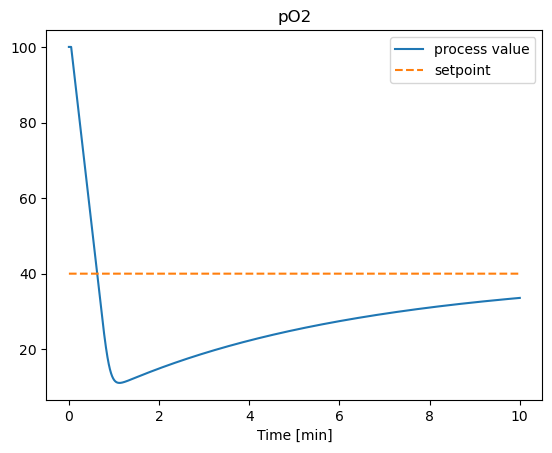

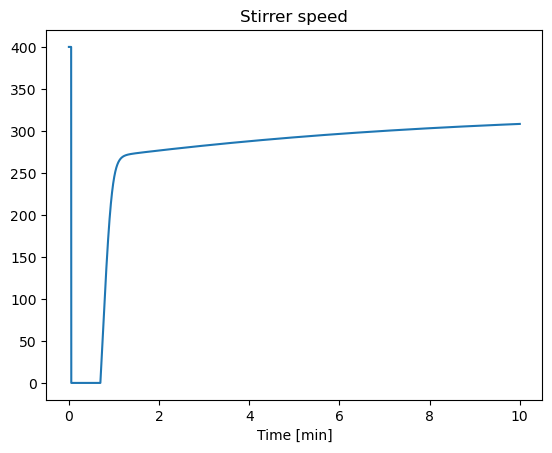

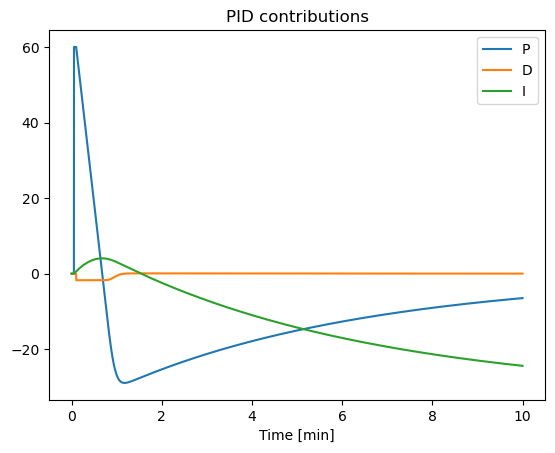

In [4]:
def kla(N):
    # kla [1/h] as function of stirrer speed [rpm]
    kla = 1e-3 * N**2
    return kla


def dc_dt(c, N): # oxygen balance, in g/L/s
    return (kla(N)*(ceq - c) - cX * qO2) / 3600

tgrid = np.linspace(0,10*60,10001) # time grid, in s
N_t = len(tgrid)
c_t = np.empty(N_t)
pO2 = np.empty(N_t)
N = np.empty(N_t)


P = np.empty(N_t)
D = np.empty(N_t)
I = np.empty(N_t)


delay = int(delay_sec/np.mean(np.diff(tgrid))) # delay in time steps

closedloop = True

for i in range(N_t):
    if i<delay+1:
        c_t[i] = ceq
    else:
        dt = tgrid[i] - tgrid[i-1]
        c_t[i] = c_t[i-1] + dc_dt(c_t[i-1], N[i-1]) * dt # explicit Euler step
        if c_t[i] < 0:
            c_t[i] = 0
            
    if (not closedloop) | i<delay+1:
        P[i] = 0
        D[i] = 0
        I[i] = 0
        N[i] = N_init
    else:
        # controller
        j = i-delay+1
        e = pO2[:j] - setpoint
        P[i] = e[-1]
        D[i] = (e[-1] - e[-2])/dt
        I[i] = np.trapz(e, tgrid[:j])

        N[i] = -y_h / XP * (P[i] + TD*D[i] + 1/TI*I[i])  
    
    if N[i] > y_h:
        N[i] = y_h
    if N[i] < 0:
        N[i] = 0
        
    pO2[i] = c_t[i]/ceq*100

plt.plot(tgrid/60, pO2, tgrid/60, tgrid*0 + setpoint, '--')
plt.title('pO2')
plt.xlabel('Time [min]')
plt.legend(['process value','setpoint'])

plt.figure()
plt.plot(tgrid/60, N)
plt.title('Stirrer speed')
plt.xlabel('Time [min]')

plt.figure()
plt.plot(tgrid/60, P,tgrid/60, TD*D,tgrid/60, 1/TI*I)
plt.legend(['P','D','I'])
plt.title('PID contributions')
plt.xlabel('Time [min]')
